In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

/opt/anaconda3/envs/ada/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


you have to figure out how you can use the work iarantsoa did in this file + change this:<br>
user_style_matrix_scaled<br>
to adapt to what she has

In [3]:
df = pd.read_csv('../../knnData/BA_US_knn_text.csv')

              Feature  Importance
0                 abv    0.294771
7  encoded_beer_style    0.242204
6              rating    0.127479
1          appearance    0.088062
2               aroma    0.083075
5             overall    0.060770
3              palate    0.055684
4               taste    0.047954


/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_77764/2653336084.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')


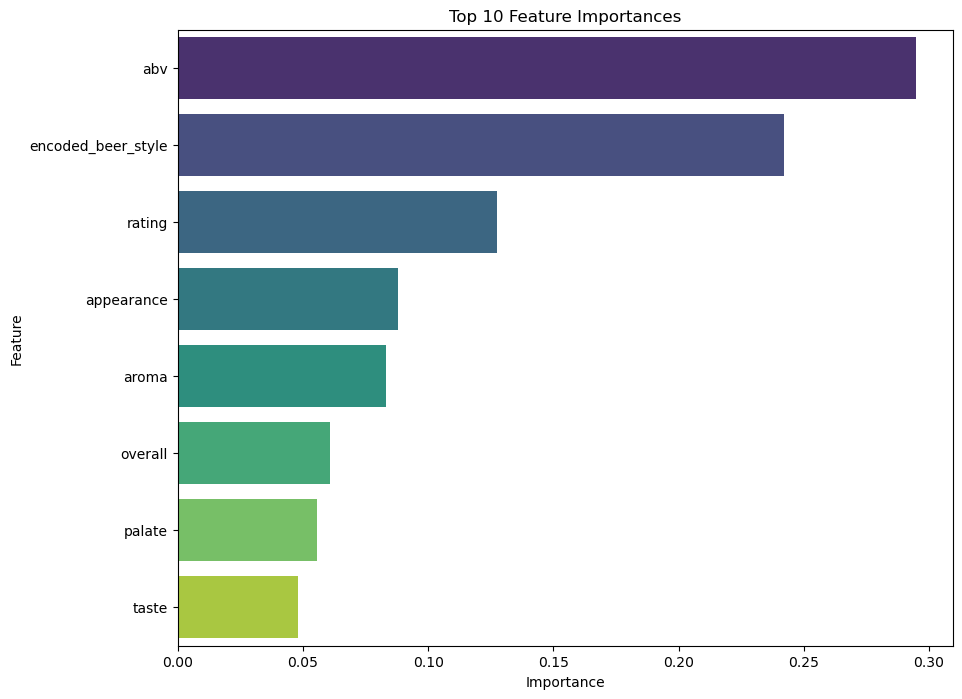

         abv  appearance  aroma  palate  taste  overall  rating  \
0        4.4        2.50   4.00    4.00   3.75     3.75    3.76   
1        4.6        3.00   3.75    4.00   3.50     3.50    3.58   
2        5.4        3.75   3.25    3.75   3.50     3.50    3.48   
3        7.3        3.25   3.75    3.50   4.25     4.25    4.00   
4        7.3        4.00   4.25    3.75   4.00     4.00    4.04   
...      ...         ...    ...     ...    ...      ...     ...   
6331633  6.8        3.50   3.00    3.50   3.00     3.50    3.18   
6331634  5.0        3.50   3.50    3.50   4.00     4.00    3.80   
6331635  5.0        3.00   3.00    3.00   2.50     3.00    2.80   
6331636  5.0        3.00   1.50    1.00   1.50     1.50    1.54   
6331637  5.3        3.00   3.00    3.00   3.00     3.00    3.00   

         encoded_beer_style  
0                  0.005233  
1                  0.003188  
2                  0.014050  
3                  0.008968  
4                  0.008968  
...            

In [4]:
%run param_selec.ipynb

You are using iterative imputation, which predicts the missing values based on the other features (see param_selec.ipynb => there are ~2.7 million Nan values in certain columns)<br>


/opt/anaconda3/envs/ada/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


abv                   0
appearance            0
aroma                 0
palate                0
taste                 0
overall               0
rating                0
encoded_beer_style    0
dtype: int64


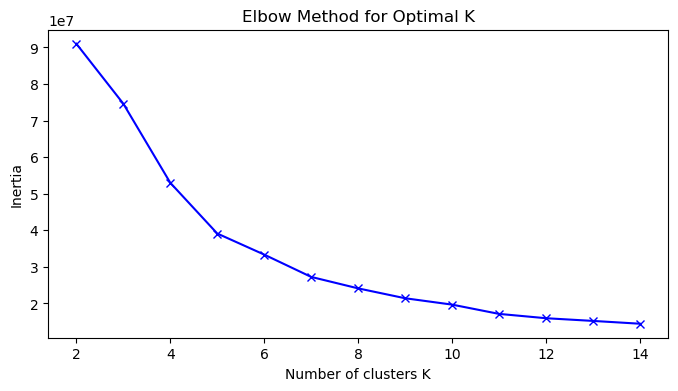

In [5]:
iter_imputer = IterativeImputer(random_state=42)
X_iter_imputed = pd.DataFrame(iter_imputer.fit_transform(X), columns=X.columns)

print(X_iter_imputed.isnull().sum())

#scaler = StandardScaler()
scaler = RobustScaler()
#scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_iter_imputed), columns=X_iter_imputed.columns)

inertia = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels

#silhouette_avg = silhouette_score(X_scaled.drop('cluster', axis=1), cluster_labels)
#print(f'Silhouette Score for K={optimal_k}: {silhouette_avg}')

You want to look for the "elbow" point in the inertia plot (how close the points are to their center of cluster) => you pick starting that point<br>
=> us around 5 or 6 or 7

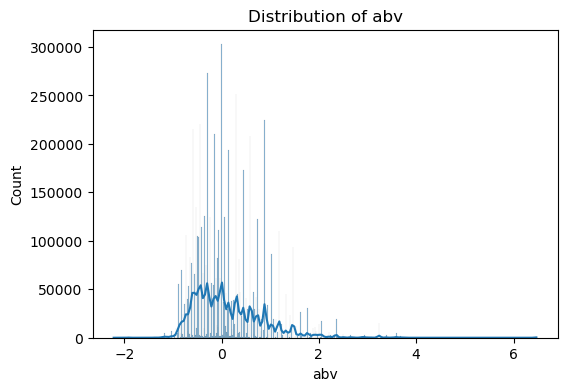

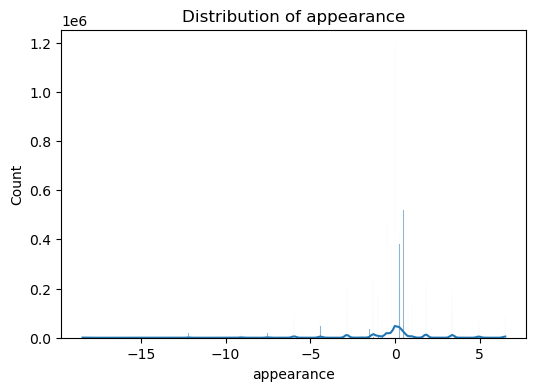

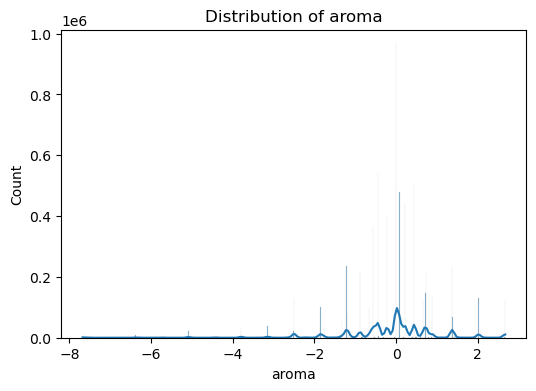

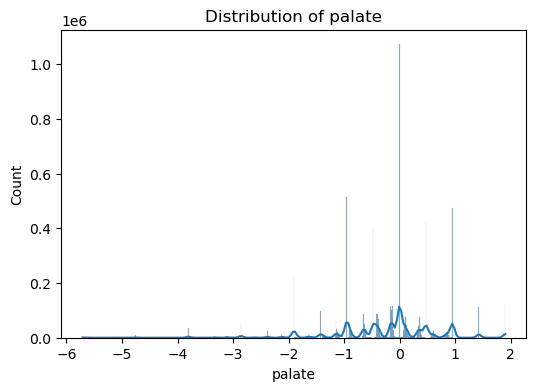

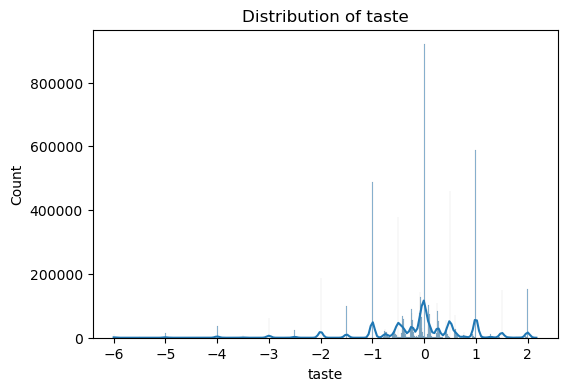

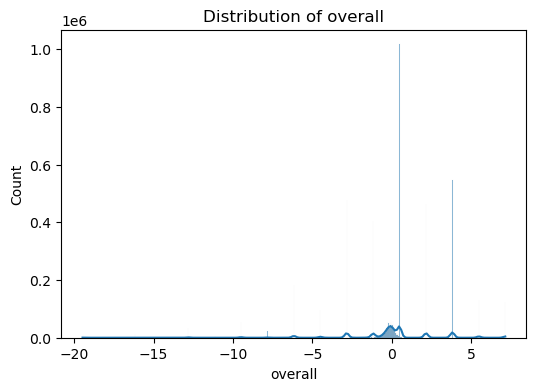

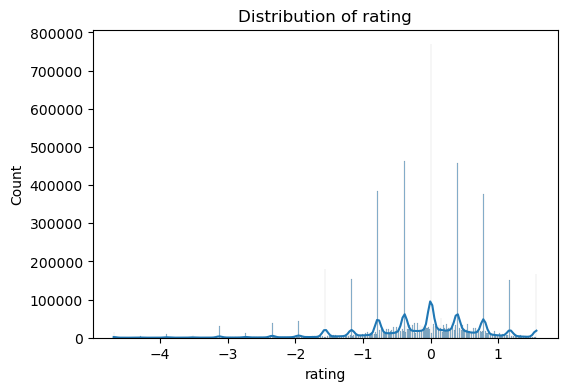

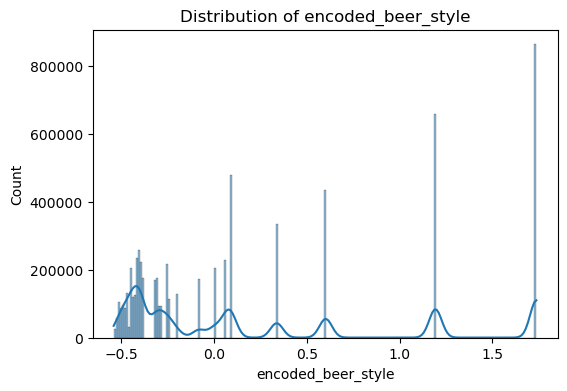

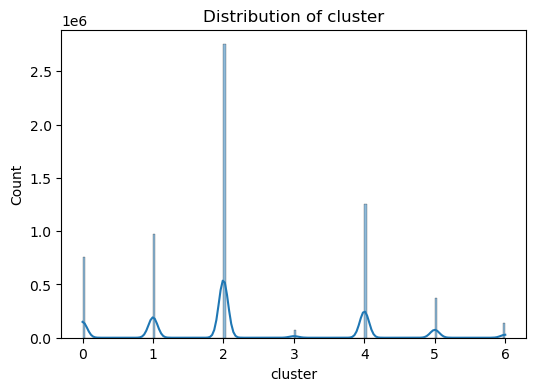

In [6]:
for column in X_scaled.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_scaled[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


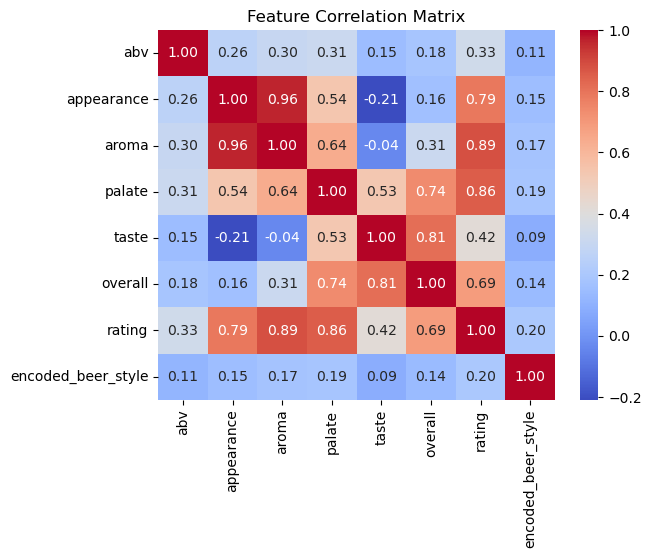

In [7]:
corr_matrix = X_scaled.drop('cluster', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [8]:
df.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,user_id,appearance,aroma,palate,taste,overall,rating,text,avg,user_state,beer_state
0,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,4.4,n2185.211743,2.50,4.00,4.00,3.75,3.75,3.76,NaN,3.76,North Carolina,Wisconsin
1,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,4.6,n2185.211743,3.00,3.75,4.00,3.50,3.50,3.58,NaN,3.58,North Carolina,Wisconsin
2,One Cent Wheat,289319.0,Copper State Brewing Company,49595.0,Witbier,5.4,n2185.211743,3.75,3.25,3.75,3.50,3.50,3.48,NaN,3.48,North Carolina,Wisconsin
3,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,7.3,n2185.211743,3.25,3.75,3.50,4.25,4.25,4.00,NaN,4.02,North Carolina,Wisconsin
4,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,7.3,angerhaus.1049226,4.00,4.25,3.75,4.00,4.00,4.04,NaN,4.02,Wisconsin,Wisconsin


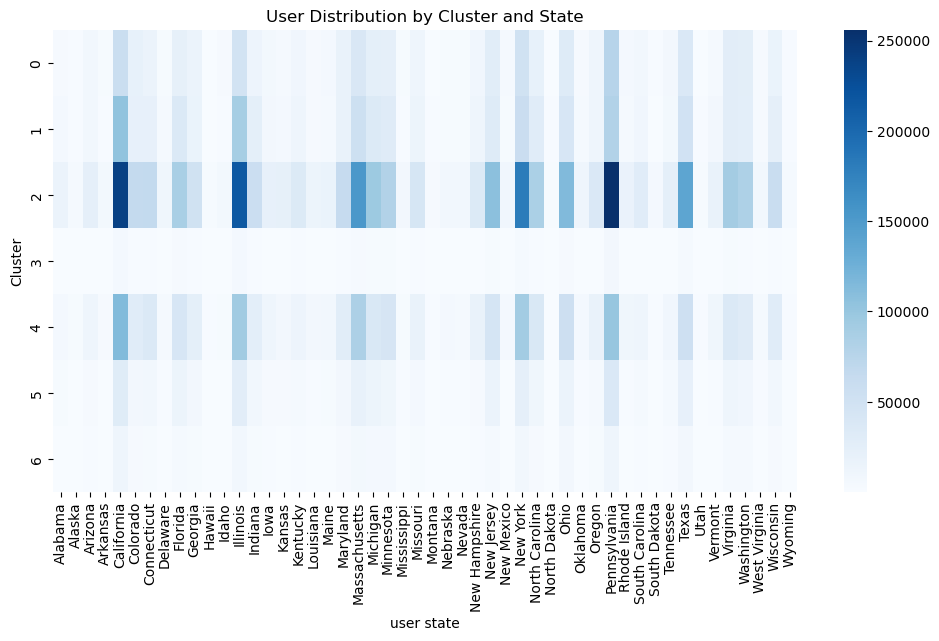

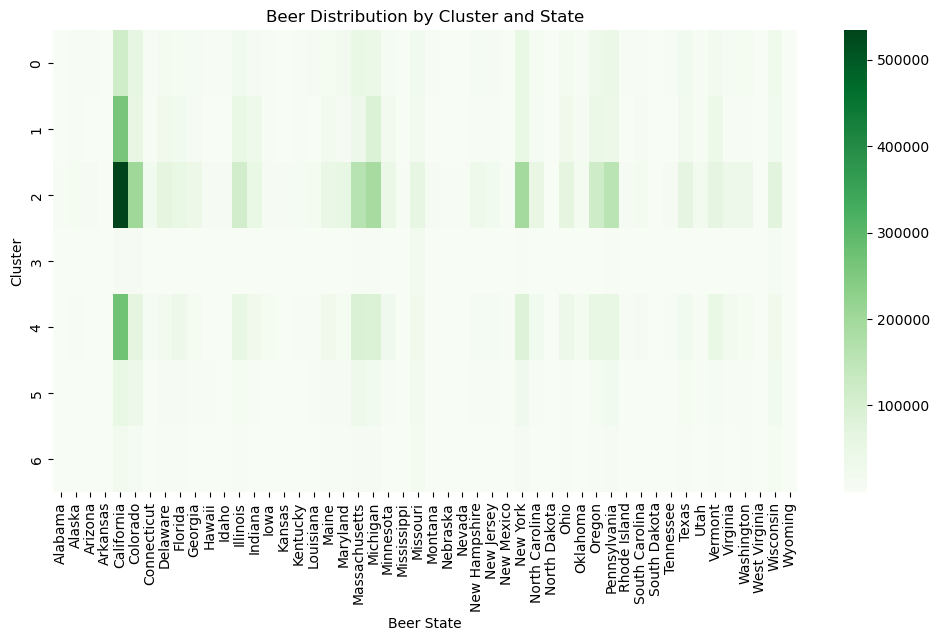

In [9]:
cluster_labels_df = X_scaled[['cluster']].reset_index(drop=True)
cluster_labels_df['user_id'] = df['user_id'].values
cluster_labels_df['beer_id'] = df['beer_id'].values

cluster_labels_df = cluster_labels_df.merge(
    df[['user_id', 'user_state']].drop_duplicates(),
    on='user_id',
    how='left'
)

if 'beer_id' in df.columns:
    cluster_labels_df = cluster_labels_df.merge(
        df[['beer_id', 'beer_state']].drop_duplicates(),
        on='beer_id',
        how='left'
    )

user_cluster_state_counts = cluster_labels_df.groupby(['cluster', 'user_state']).size().unstack(fill_value=0)

if 'beer_state' in cluster_labels_df.columns:
    beer_cluster_state_counts = cluster_labels_df.groupby(['cluster', 'beer_state']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(user_cluster_state_counts, annot=False, fmt='d', cmap='Blues')
plt.title('User Distribution by Cluster and State')
plt.xlabel('user state')
plt.ylabel('Cluster')
plt.show()

if 'beer_state' in cluster_labels_df.columns:
    plt.figure(figsize=(12, 6))
    sns.heatmap(beer_cluster_state_counts, annot=False, fmt='d', cmap='Greens')
    plt.title('Beer Distribution by Cluster and State')
    plt.xlabel('Beer State')
    plt.ylabel('Cluster')
    plt.show()


In [12]:
user_cluster_state_counts_t = user_cluster_state_counts.T
user_cluster_state_counts_t

cluster,0,1,2,3,4,5,6
user_state,,,,,,,
Alabama,4008,5193,16013,618,5675,3003,802
Alaska,1464,1522,4738,78,2661,468,287
Arizona,8097,8876,23140,632,12574,3107,1365
Arkansas,2142,1768,6609,352,3830,1020,311
California,58145,104954,239386,5855,113809,30754,11213
Colorado,20635,21535,65049,1343,29144,7451,3603
Connecticut,15610,21744,66279,1493,36534,8469,2500
Delaware,2339,4087,10387,348,4699,1805,297
Florida,22571,36682,87605,3104,41101,14103,4551


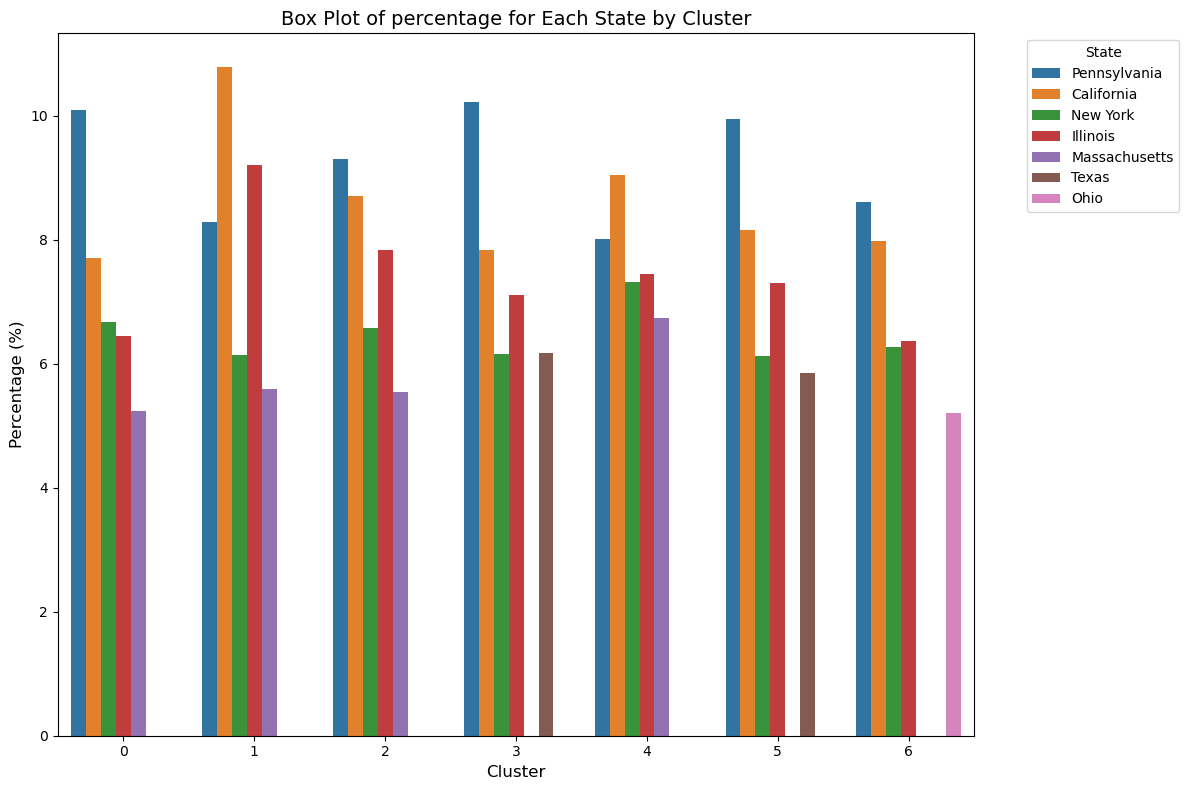

In [22]:
top_5_data =[]
cluster_totals = user_cluster_state_counts_t.sum(axis=0)
#print(cluster_totals[1])
i = 0
for clusters in user_cluster_state_counts_t.items():
    #print(clusters[0])
    #print(clusters[1].nlargest(5))
    #print(clusters[1].nlargest(5).values)

    top_states = clusters[1].nlargest(5).index
    top_values = clusters[1].nlargest(5).values
    #print(cluster_totals[i])
    top_percentages = (top_values / cluster_totals[i]) * 100
    
    top_5_data.append(pd.DataFrame({'state': top_states, 'percentage': top_percentages, 'cluster': clusters[0]}))
    #print(top_5_data)
    i += 1
top_5_df = pd.concat(top_5_data)
#print(top_5_df)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_5_df, x='cluster', y='percentage', hue='state', dodge=True)

plt.title("Box Plot of percentage for Each State by Cluster", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



/opt/anaconda3/envs/ada/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


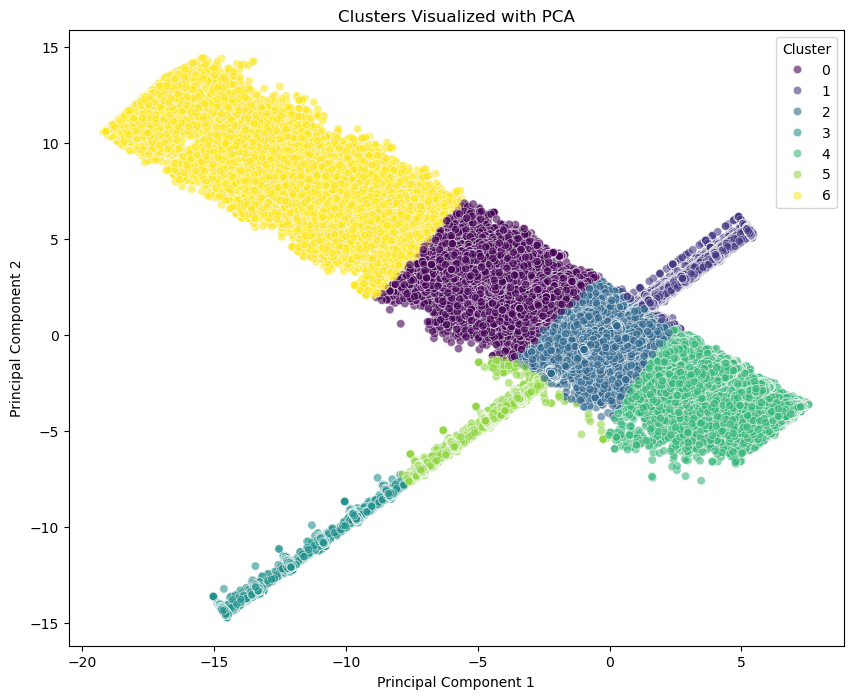

Explained Variance by PC1: 0.57
Explained Variance by PC2: 0.36


In [8]:
features = X_scaled.drop('cluster', axis=1)

pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette='viridis',
    data=pca_df,
    alpha=0.6
)
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by PC1: {explained_variance[0]:.2f}')
print(f'Explained Variance by PC2: {explained_variance[1]:.2f}')


In [10]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

tsne_results = tsne.fit_transform(features)

tsne_df = pd.DataFrame(data=tsne_results, columns=['Dim1', 'Dim2'])
tsne_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim1', y='Dim2',
    hue='Cluster',
    palette='viridis',
    data=tsne_df,
    alpha=0.6
)
plt.title('Clusters Visualized with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cluster')
plt.show()


/opt/anaconda3/envs/ada/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 

In [11]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)

umap_results = umap_reducer.fit_transform(features)

umap_df = pd.DataFrame(data=umap_results, columns=['UMAP1', 'UMAP2'])
umap_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='Cluster',
    palette='viridis',
    data=umap_df,
    alpha=0.6
)
plt.title('Clusters Visualized with UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.show()


/opt/anaconda3/envs/ada/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


: 

: 

In [ ]:
pca_3d = PCA(n_components=3, random_state=42)
principal_components_3d = pca_3d.fit_transform(features)

pca_3d_df = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
pca_3d_df['Cluster'] = cluster_labels

fig = px.scatter_3d(
    pca_3d_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='3D Visualization of Clusters using PCA',
    opacity=0.7
)

fig.show()


you should try bringing up the # of clusters <br>
you should see how you can give more importance to certain features with KNN (maybe brewery is more important?)<br>


In [76]:

# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add labels to DataFrame
X_scaled['DBSCAN_Cluster'] = dbscan_labels

# Visualize with PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled.drop(['DBSCAN_Cluster'], axis=1))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['DBSCAN_Cluster'] = dbscan_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='DBSCAN_Cluster',
    palette='viridis',
    data=pca_df,
    alpha=0.6
)
plt.title('DBSCAN Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


: 

: 